In [1]:
#!pip install beautifulsoup4
#!pip install requests
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from plotnine import *

1. using beautiful soup to scrape data for Starbucks and Dunkin Donuts (automated for other sites as well)

In [2]:
# chatgpt helped write and edit this code
def scrape_table(url):
    # Request the content of the webpage
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the first table on the page
    table = soup.find_all("table")[0]

    # Attempt to get headers from <th>, falling back to the first row if <th> is absent
    headers = []
    header_row = table.find_all("tr")[0]
    for header in header_row.find_all(["th", "td"]):
        header_text = ''.join(header.stripped_strings)
        headers.append(header_text)

    # Initialize list to store each row's data
    rows = []
    
    # Loop over rows in the table to capture each data row
    for row in table.find_all("tr")[1:]:
        cells = row.find_all("td")
        # Use the first cell as the state name and get text directly
        state_cell = row.find("th") or (cells[0] if cells else None)
        
        # If there's no row label cell, skip the row
        if state_cell:
            state = state_cell.get_text(strip=True)  # This is the state name
            row_data = {"State": state}  # Initialize with state
            
            # Add each cell's data to the row using headers, starting from index 1
            for i in range(len(cells)):
                if i + 1 < len(headers):  # Ensure we don’t exceed headers list
                    cell_text = ''.join(cells[i].stripped_strings)
                    column_name = headers[i + 1]  # Adjust to use the correct header
                    row_data[column_name] = cell_text
            
            rows.append(row_data)
    
    # Convert to a DataFrame with dynamic columns, ensuring headers are unique
    df = pd.DataFrame(rows, columns=["State"] + headers[1:])
    
    # Reshape the DataFrame to long format
    df_melted = df.melt(id_vars=["State"], var_name="Year", value_name="Store_Count")
    
    # Extract year from column names and clean up
    df_melted['Year'] = df_melted['Year'].str.extract('(\d+)')
    
    # Clean up the Store_Count column, removing commas and converting to integer
    df_melted['Store_Count'] = df_melted['Store_Count'].str.replace(',', '').replace('', '0')
    df_melted['Store_Count'] = df_melted['Store_Count'].astype(int)
    
    return df_melted

<positron-console-cell-2>:47: SyntaxWarning: invalid escape sequence '\d'


2. parsing and merging data

In [3]:
def fetch_and_merge_tables(urls):
    all_data = []
    
    for url in urls:
        # Scrape and tidy the table from each URL
        df = scrape_table(url)
        
        # Determine the chain based on the URL and assign it to a new column
        if "starbucks" in url.lower():
            df['Chain'] = 'Starbucks'
        elif "dunkin" in url.lower():
            df['Chain'] = 'Dunkin'
        else:
            df['Chain'] = 'Unknown'
        
        # Append the data to the list
        all_data.append(df)
    
    # Concatenate all dataframes
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Select and order final columns
    merged_df = merged_df[['State', 'Year', 'Store_Count', 'Chain']]
    
    return merged_df

In [4]:
# Define the URLs for Starbucks and Dunkin
urls = [
    "https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state",
    "https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state"
]

# Fetch, clean, reshape, and merge data for Starbucks and Dunkin
merged_coffee_df = fetch_and_merge_tables(urls)
merged_coffee_df

,State,Year,Store_Count,Chain
0,California,2023,3080,Starbucks
1,Texas,2023,1346,Starbucks
2,Florida,2023,844,Starbucks
3,Washington,2023,741,Starbucks
4,New York,2023,692,Starbucks
...,...,...,...,...
250,Montana,2023,0,Dunkin
251,North Dakota,2023,0,Dunkin
252,Oregon,2023,0,Dunkin
253,South Dakota,2023,0,Dunkin


In [5]:
# testing for other website
test_urls = [
    "https://worldpopulationreview.com/state-rankings/krispy-kreme-by-state",
    "https://worldpopulationreview.com/state-rankings/walmart-stores-by-state"
]

test_df = fetch_and_merge_tables(test_urls)
test_df

,State,Year,Store_Count,Chain
0,California,NaN,40,Unknown
1,Florida,NaN,32,Unknown
2,Georgia,NaN,30,Unknown
3,North Carolina,NaN,27,Unknown
4,Texas,NaN,24,Unknown
...,...,...,...,...
96,Hawaii,NaN,10,Unknown
97,Alaska,NaN,9,Unknown
98,Rhode Island,NaN,9,Unknown
99,Vermont,NaN,6,Unknown


4. scraping state names and populations from https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population and merging with coffee dataset

In [6]:
# chatgpt helped write and edit this code
def scrape_table2(url):
    # Request the content of the webpage
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the first table on the page
    table = soup.find_all("table")[0]

    # Get headers from <th>
    headers = []
    header_row = table.find_all("tr")[0]
    
    for header in header_row.find_all("th"):
        header_text = ''.join(header.stripped_strings)  # Get text, stripping whitespace
        headers.append(header_text)

    # Initialize list to store each row's data
    rows = []
    
    # Loop over rows in the table to capture each data row
    for row in table.find_all("tr")[1:]:
        cells = row.find_all("td")
        if cells:  # Ensure there are cells
            row_data = {}
            for i, cell in enumerate(cells):
                # Capture the state name from the anchor tag
                if i == 2:  # The index for the State column
                    state_name = cell.find('a').get_text(strip=True) if cell.find('a') else ''
                    row_data['State'] = state_name
                else:
                    cell_text = ''.join(cell.stripped_strings)
                    row_data[headers[i]] = cell_text
            
            rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

In [7]:
# Scrape data from the table
url = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"
state_population_df = scrape_table2(url)

# Identify the correct column names
print("Column names:", state_population_df.columns)
state_population_df.head()

Column names: Index(['Rank in states & territories, 2020',
       'Rank in states & territories, 2010', 'State',
       'Census population, April 1, 2020[1][2]',
       'Census population, April 1, 2010[1][2]',
       'Percent change, 2010–2020[note 1]', 'Absolute change, 2010-2020',
       'Total seats in theU.S. House of Representatives, 2023–2033',
       'Census population per electoral vote[note 2]',
       'Census population per House seat',
       'Percent of the total U.S. population, 2020[note 3]'],
      dtype='object')
Column names: Index(['Rank in states & territories, 2020',
       'Rank in states & territories, 2010', 'State',
       'Census population, April 1, 2020[1][2]',
       'Census population, April 1, 2010[1][2]',
       'Percent change, 2010–2020[note 1]', 'Absolute change, 2010-2020',
       'Total seats in theU.S. House of Representatives, 2023–2033',
       'Census population per electoral vote[note 2]',
       'Census population per House seat',
       'Perc

,"Rank in states & territories, 2020","Rank in states & territories, 2010",State,"Census population, April 1, 2020[1][2]","Census population, April 1, 2010[1][2]","Percent change, 2010–2020[note 1]","Absolute change, 2010-2020","Total seats in theU.S. House of Representatives, 2023–2033",Census population per electoral vote[note 2],Census population per House seat,"Percent of the total U.S. population, 2020[note 3]"
0,1,1,California,"39,538,223","37,253,956",6.1%,"+2,284,267",52,"732,189","760,350",11.80%
1,2,2,Texas,"30,145,505","25,145,561",15.9%,"+3,999,944",38,"728,638","766,987",8.70%
2,3,4,Florida,"21,538,187","18,801,310",14.6%,"+2,736,877",28,"717,940","769,221",6.43%
3,4,3,New York,"20,201,249","19,378,102",4.2%,"+823,147",26,"721,473","776,971",6.03%
4,5,6,Pennsylvania,"13,002,700","12,702,379",2.4%,"+300,321",17,"684,353","764,865",3.88%


In [8]:
# chatgpt helped annotate and edit this code
# Filter to get just the State and Population columns, renaming Population for clarity
state_population_df = state_population_df[["State", "Census population, April 1, 2020[1][2]"]].rename(
    columns={"Census population, April 1, 2020[1][2]": "Population"}
)

# Convert the Population column to integer, removing commas
state_population_df["Population"] = state_population_df["Population"].str.replace(",", "").astype(int)

# Merge the population data with the merged coffee DataFrame on the "State" column
merged_coffee_df = merged_coffee_df.merge(state_population_df, on="State", how="left")

merged_coffee_df.head()

,State,Year,Store_Count,Chain,Population
0,California,2023,3080,Starbucks,39538223
1,Texas,2023,1346,Starbucks,30145505
2,Florida,2023,844,Starbucks,21538187
3,Washington,2023,741,Starbucks,7705281
4,New York,2023,692,Starbucks,20201249


5. merging revenues for each company into coffee dataset

In [9]:
# chatgpt helped write and edit this code
# Define U.S. states and population-based weighting
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", 
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", 
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", 
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", 
    "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", 
    "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", 
    "Utah", "Vermont", "Virginia", "Washington", "West Virginia", 
    "Wisconsin", "Wyoming", "District of Columbia"
]

# Sample population multipliers to weight states (not exact, just to create realistic variations)
population_weights = np.array([
    0.013, 0.002, 0.021, 0.009, 0.12, 0.017, 0.011, 0.003, 0.063, 0.032, 
    0.004, 0.005, 0.039, 0.021, 0.009, 0.006, 0.014, 0.013, 0.003, 0.019, 
    0.021, 0.033, 0.018, 0.008, 0.017, 0.004, 0.006, 0.009, 0.004, 0.022, 
    0.006, 0.086, 0.033, 0.002, 0.038, 0.011, 0.013, 0.039, 0.003, 0.016, 
    0.002, 0.021, 0.085, 0.007, 0.001, 0.022, 0.027, 0.005, 0.017, 0.002, 
    0.001
])

# Starbucks Revenue: Generally higher in West and large metro areas
starbucks_base_revenue = 500000  # base revenue amount
starbucks_regional_multiplier = np.array([
    1.2 if state in ["California", "Washington", "Oregon"] else 1.0 for state in states
])
starbucks_revenue = (starbucks_base_revenue * population_weights * starbucks_regional_multiplier * 
                     np.random.uniform(0.9, 1.1, size=len(states))).astype(int)

# Dunkin Revenue: Strong in Northeast, less in West
dunkin_base_revenue = 450000  # slightly lower base revenue amount
dunkin_regional_multiplier = np.array([
    1.3 if state in ["New York", "Massachusetts", "Connecticut", "New Jersey"] else 0.7 if state in ["California", "Oregon", "Washington"] else 1.0
    for state in states
])
dunkin_revenue = (dunkin_base_revenue * population_weights * dunkin_regional_multiplier * 
                  np.random.uniform(0.9, 1.1, size=len(states))).astype(int)

# Create DataFrames
starbucks_rev_df = pd.DataFrame({
    "State": states,
    "Revenue ($millions)": starbucks_revenue
})

dunkin_rev_df = pd.DataFrame({
    "State": states,
    "Revenue ($millions)": dunkin_revenue
})

# Display first few rows of each DataFrame
print("Starbucks Revenue by State:")
print(starbucks_rev_df.head())

print("\nDunkin Donuts Revenue by State:")
print(dunkin_rev_df.head())

Starbucks Revenue by State:
        State  Revenue ($millions)
0     Alabama                 5900
1      Alaska                 1014
2     Arizona                 9837
3    Arkansas                 4324
4  California                66907

Dunkin Donuts Revenue by State:
        State  Revenue ($millions)
0     Alabama                 5973
1      Alaska                  847
2     Arizona                 9513
3    Arkansas                 3926
4  California                36103
Starbucks Revenue by State:
        State  Revenue ($millions)
0     Alabama                 5900
1      Alaska                 1014
2     Arizona                 9837
3    Arkansas                 4324
4  California                66907

Dunkin Donuts Revenue by State:
        State  Revenue ($millions)
0     Alabama                 5973
1      Alaska                  847
2     Arizona                 9513
3    Arkansas                 3926
4  California                36103


In [10]:
# chatgpt helped annotate and edit this code
# First, create a combined revenue DataFrame with both Starbucks and Dunkin data
starbucks_rev_df['Chain'] = 'Starbucks'
dunkin_rev_df['Chain'] = 'Dunkin'

# Concatenate both revenue DataFrames
combined_revenue_df = pd.concat([starbucks_rev_df, dunkin_rev_df], ignore_index=True)

# Now, merge this combined revenue DataFrame with merged_coffee_df on both 'State' and 'Chain'
merged_coffee_df = merged_coffee_df.merge(
    combined_revenue_df[['State', 'Chain', 'Revenue ($millions)']],
    on=['State', 'Chain'],
    how='left'
)

merged_coffee_df

,State,Year,Store_Count,Chain,Population,Revenue ($millions)
0,California,2023,3080,Starbucks,39538223,66907
1,Texas,2023,1346,Starbucks,30145505,41070
2,Florida,2023,844,Starbucks,21538187,34044
3,Washington,2023,741,Starbucks,7705281,17421
4,New York,2023,692,Starbucks,20201249,44097
...,...,...,...,...,...,...
250,Montana,2023,0,Dunkin,1084225,1779
251,North Dakota,2023,0,Dunkin,779094,934
252,Oregon,2023,0,Dunkin,4237256,4383
253,South Dakota,2023,0,Dunkin,886667,942


6. Create a region variable in your dataset according to the scheme on this wikipedia page: Northeast, Midwest, South, West. You do not need to scrape this information.

In [11]:
# chatgpt helped annotate and edit this code
region_mapping = {
    "Connecticut": "Northeast", "Maine": "Northeast", "Massachusetts": "Northeast",
    "New Hampshire": "Northeast", "Rhode Island": "Northeast", "Vermont": "Northeast",
    "New Jersey": "Northeast", "New York": "Northeast", "Pennsylvania": "Northeast",
    
    "Illinois": "Midwest", "Indiana": "Midwest", "Michigan": "Midwest",
    "Ohio": "Midwest", "Wisconsin": "Midwest",
    "Iowa": "Midwest", "Kansas": "Midwest", "Minnesota": "Midwest",
    "Missouri": "Midwest", "Nebraska": "Midwest", "North Dakota": "Midwest",
    "South Dakota": "Midwest",
    
    "Delaware": "South", "Florida": "South", "Georgia": "South",
    "Maryland": "South", "North Carolina": "South", "South Carolina": "South",
    "Virginia": "South", "West Virginia": "South", "Washington D.C.": "South",
    
    "Alabama": "South", "Kentucky": "South", "Mississippi": "South",
    "Tennessee": "South",
    
    "Arkansas": "South", "Louisiana": "South", "Oklahoma": "South", "Texas": "South",
    
    "Arizona": "West", "Colorado": "West", "Idaho": "West",
    "Montana": "West", "Nevada": "West", "New Mexico": "West",
    "Utah": "West", "Wyoming": "West",
    
    "Alaska": "West", "California": "West", "Hawaii": "West", "Oregon": "West",
    "Washington": "West"
}

# Create DataFrame to map regions and states
region_df = pd.DataFrame(list(region_mapping.items()), columns=['State', 'Region'])

# Merge the region DataFrame with the merged_coffee_df on the 'State' column
merged_coffee_df = merged_coffee_df.merge(region_df, on='State', how='left')

# Display the updated DataFrame
merged_coffee_df

,State,Year,Store_Count,Chain,Population,Revenue ($millions),Region
0,California,2023,3080,Starbucks,39538223,66907,West
1,Texas,2023,1346,Starbucks,30145505,41070,South
2,Florida,2023,844,Starbucks,21538187,34044,South
3,Washington,2023,741,Starbucks,7705281,17421,West
4,New York,2023,692,Starbucks,20201249,44097,Northeast
...,...,...,...,...,...,...,...
250,Montana,2023,0,Dunkin,1084225,1779,West
251,North Dakota,2023,0,Dunkin,779094,934,Midwest
252,Oregon,2023,0,Dunkin,4237256,4383,West
253,South Dakota,2023,0,Dunkin,886667,942,Midwest


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


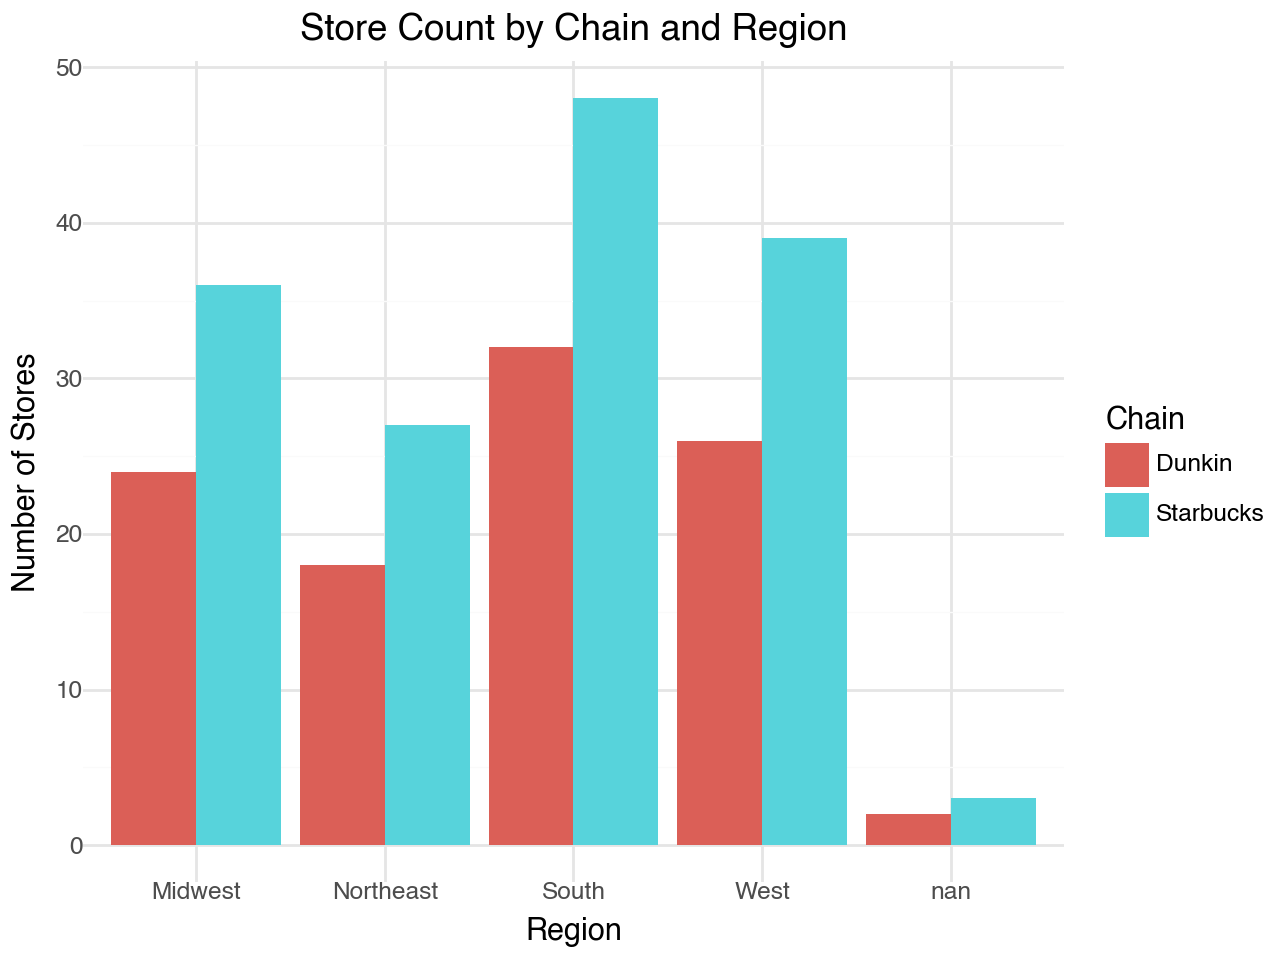

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


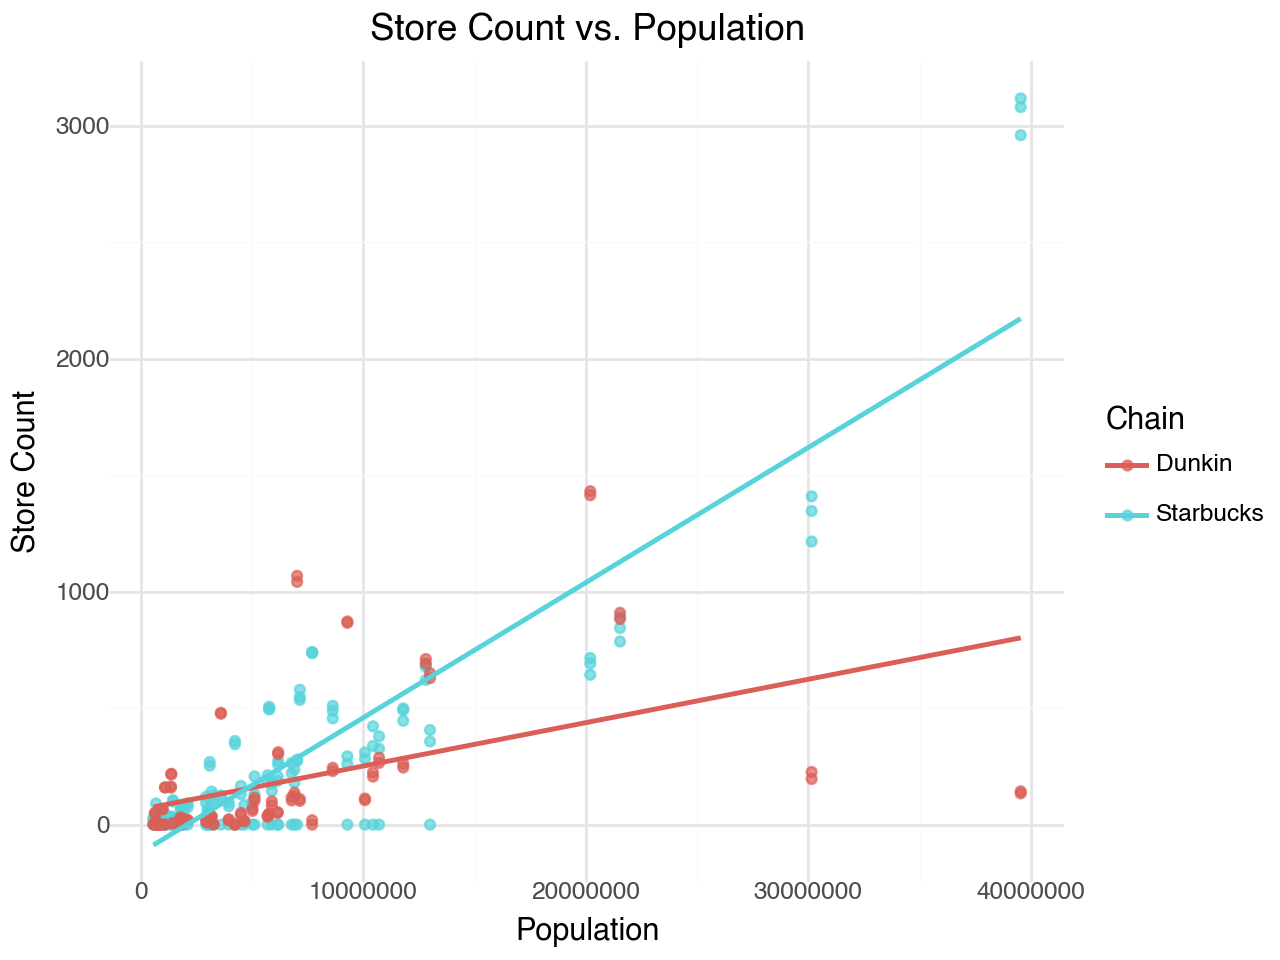

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


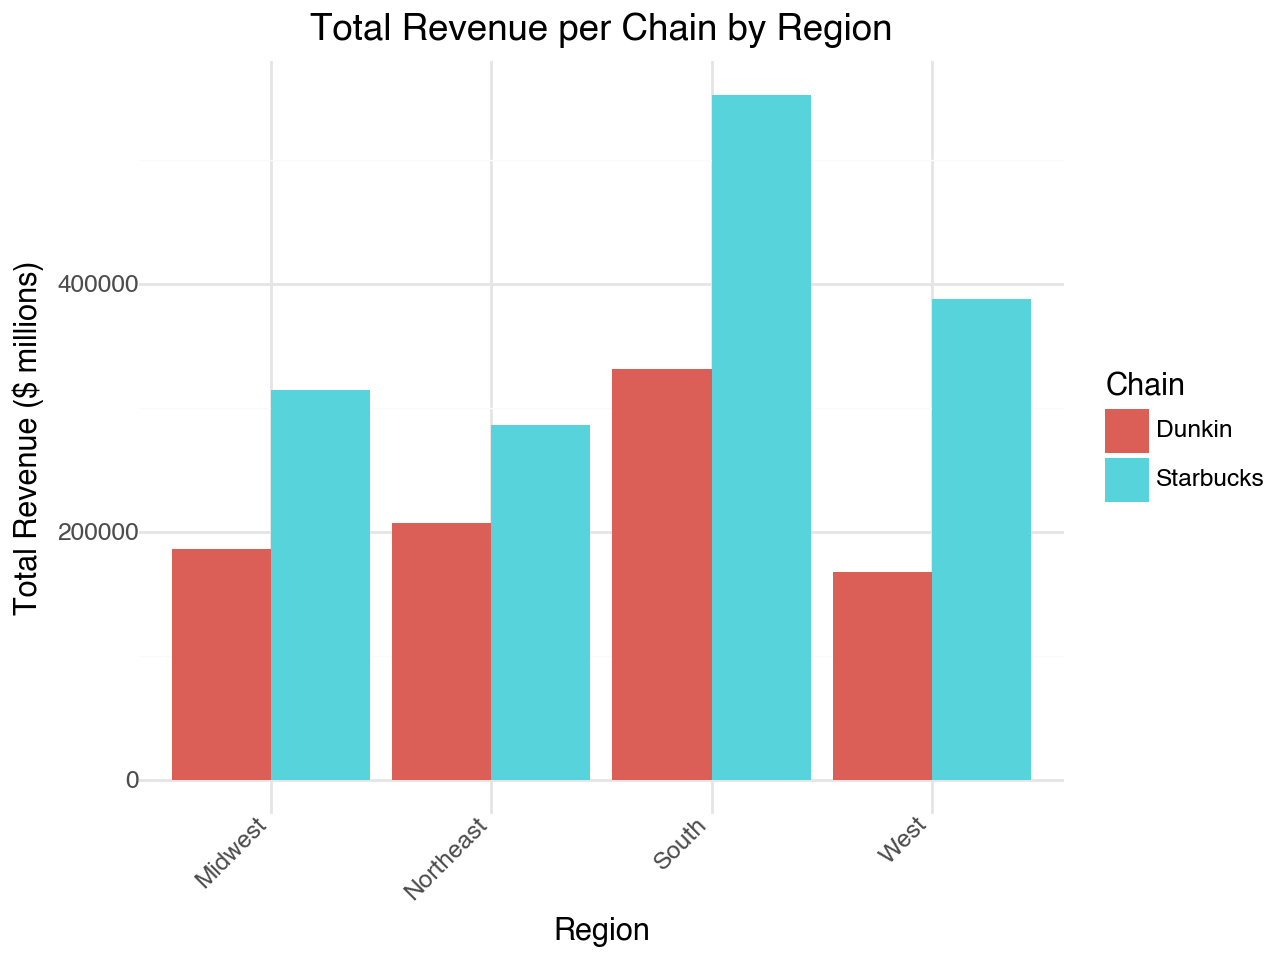

In [12]:
# ChatGPT helped write and edit this code
# Store Count by Chain and Region
store_count_region_plot = (
    ggplot(merged_coffee_df) +
    aes(x='Region', fill='Chain') +
    geom_bar(position='dodge') +
    labs(title='Store Count by Chain and Region',
         x='Region',
         y='Number of Stores') +
    theme_minimal()
)

# Store Count vs. Population
store_count_population_plot = (
    ggplot(merged_coffee_df) +
    aes(x='Population', y='Store_Count', color='Chain') +
    geom_point(alpha=0.7) +
    labs(title='Store Count vs. Population',
         x='Population',
         y='Store Count') +
    theme_minimal() +
    geom_smooth(method='lm', se=False)
)

# Revenue of Chain by Region
# Revenue of Chains summed up
revenue_by_chain_region = (
    merged_coffee_df
    .groupby(['Chain', 'Region'], as_index=False)
    .agg({'Revenue ($millions)': 'sum'})
)

# Revenue of Chain by Region Plot
revenue_chain_region_plot = (
    ggplot(revenue_by_chain_region) +
    aes(x='Region', y='Revenue ($millions)', fill='Chain') +
    geom_bar(stat='identity', position='dodge') +
    labs(title='Total Revenue per Chain by Region',
         x='Region',
         y='Total Revenue ($ millions)') +
    theme_minimal() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

7. 
When looking at regional presence, Dunkin' is more concentrated in the Northeast and South, with less reach in the West and Midwest, which aligns with its traditional East Coast focus. Starbucks instead has a broader distribution and dominates in store counts across all regions, especially in the South and West.

Comparing store count and revenue, we see that while Starbucks has more locations across all regions, its revenue per region is also notably higher. This suggests that Starbucks stores may be more financially productive on a per-store basis. Starbucks' concentration in regions like the West and South, which may have higher population densities and foot traffic, likely drives this higher revenue. Dunkin’, though not as widespread in the West, still performs well revenue-wise in the Northeast, its strongest region. However, Dunkin's per-store revenue appears lower than Starbucks, likely due to differences in menu pricing, customer experience, and brand positioning.

The relationship between store count and population also reveals some interesting patterns. Starbucks has a strong positive correlation with population size, indicating that it tends to establish more stores in populous areas. Dunkin' shows a positive correlation as well, though weaker, suggesting that it may be more selective or limited in urban, high-population areas, possibly due to a more targeted regional strategy.

Overall, Starbucks maintains a broader and more balanced regional presence, with stronger financial performance per store and a clearer link between store count and population. Dunkin' continues to focus more regionally, especially in the Northeast, but with lower average revenue per store. These differences in reach and financial performance may stem from each brand’s unique approach to location selection and target market.